# IA2025 Autoencoder PyTorch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from  torch.utils.data import DataLoader, SubsetRandomSampler
import torch.optim
from torchvision import datasets,transforms

## Defining transforms

In [2]:
transforms=transforms.ToTensor()

## Downloading required data

In [3]:
train_data=datasets.MNIST('data',train=True,download=True,transform=transforms)
test_data=datasets.MNIST('data',train=False,download=True,transform=transforms)

100%|██████████| 9.91M/9.91M [00:00<00:00, 62.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.68MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.97MB/s]


## Defining dataloaders

In [4]:
valid_size=0.2

# IMPORTANT
batch_size=20

num_workers=0

train_length = len(train_data)

# obtain training dataset indices that will be used for validation dataset
indices = list(range(train_length))

np.random.shuffle(indices)
split = int(np.floor(valid_size * train_length))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders for train, test and validation dataset
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

In [5]:
# Printing the length of our train, valid and test dataloaders
# NOTE : Here batch size is 20
len(train_loader),len(valid_loader),len(test_loader)

(2400, 600, 500)

In [7]:
# checking our data
dataiter=iter(train_loader)
# images,labels=dataiter.next() # Old way of iterating
images, labels = next(dataiter) # New way of iterating
print(images, images.shape, len(images), images[0].shape)
print()
print(labels,labels.shape,len(labels))

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

## Visualizing a Training batch

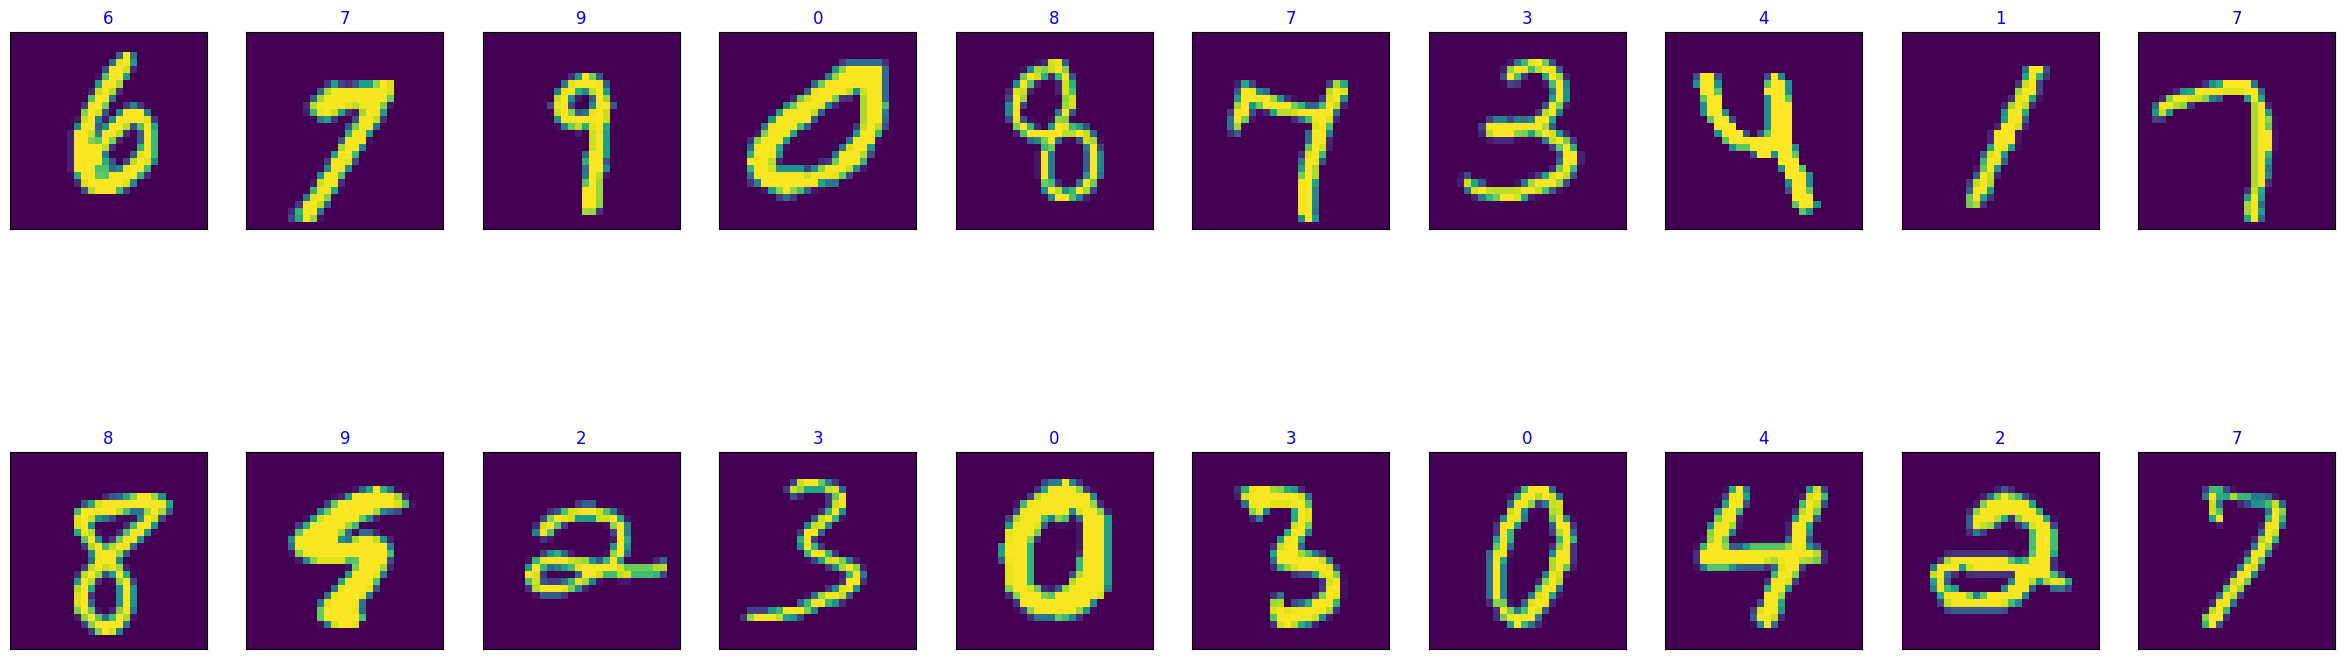

In [8]:
# Displaying images and labels of a batch
fig=plt.figure(figsize=(30,10))
for i in range(len(labels)):
    ax=fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    plt.imshow(np.squeeze(images[i]))
    ax.set_title(labels[i].item(),color='blue')

## Defining Architecture

In [9]:
class F_Auto_MNIST(nn.Module):
    def __init__(self,en_dim):
        super(F_Auto_MNIST,self).__init__()
        self.encoder=nn.Linear(784,en_dim)
        self.decoder=nn.Linear(en_dim,784)

    def forward(self,x):
        x=F.relu(self.encoder(x))
        x=F.sigmoid(self.decoder(x))
        return x

class Tran_conv_Auto_MNIST(nn.Module):
    def __init__(self):
        super(Tran_conv_Auto_MNIST,self).__init__()
        self.en_conv1=nn.Conv2d(1,16,3,padding=1)
        self.en_conv2=nn.Conv2d(16,4,3,padding=1)
        self.pool=nn.MaxPool2d(2,2)

        self.de_conv1=nn.ConvTranspose2d(4,16,2,stride=2)
        self.de_conv2=nn.ConvTranspose2d(16,1,2,stride=2)

    def forward(self,x):
        x=self.pool(F.relu(self.en_conv1(x)))
        x=self.pool(F.relu(self.en_conv2(x)))
        x=F.relu(self.de_conv1(x))
        x=F.sigmoid(self.de_conv2(x))
        return x

class upsamp_conv_Auto_MNIST(nn.Module):
    def __init__(self):
        super(upsamp_conv_Auto_MNIST,self).__init__()
        self.en_conv1=nn.Conv2d(1,16,3,padding=1)
        self.en_conv2=nn.Conv2d(16,4,3,padding=1)
        self.pool=nn.MaxPool2d(2,2)

        self.de_conv1=nn.Conv2d(4,16,3,padding=1)
        self.de_conv2=nn.Conv2d(16,1,3,padding=1)

    def forward(self,x):
        x=self.pool(F.relu(self.en_conv1(x)))
        x=self.pool(F.relu(self.en_conv2(x)))
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x=F.relu(self.de_conv1(x))
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x=F.sigmoid(self.de_conv2(x))
        return x

#Since the images are normalized between 0 and 1, we need to use a sigmoid activation on the output layer to get values that match this input value range.

In [11]:
model_1=F_Auto_MNIST(32)
model_2=Tran_conv_Auto_MNIST()
model_3=upsamp_conv_Auto_MNIST()

def weight_init_normal(m):
    classname=m.__class__.__name__
    if classname.find('Linear')!=-1:
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

model_1.apply(weight_init_normal)

use_cuda=True
if use_cuda and torch.cuda.is_available():
  model_1.cuda()
  model_2.cuda()
  model_3.cuda()
print(model_1,'\n\n\n\n',model_2,'\n\n\n\n',model_3,'\n\n\n\n','On GPU : ',torch.cuda.is_available())

F_Auto_MNIST(
  (encoder): Linear(in_features=784, out_features=32, bias=True)
  (decoder): Linear(in_features=32, out_features=784, bias=True)
) 



 Tran_conv_Auto_MNIST(
  (en_conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (en_conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (de_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (de_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
) 



 upsamp_conv_Auto_MNIST(
  (en_conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (en_conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (de_conv1): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (de_conv2): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
) 



 O

## Defining our Loss Function

In [12]:
# Used when comapring pixel values.
criterion=nn.MSELoss()

## Training and Validation Phase

In [15]:
def trainNet(model,lr,state='fully'):
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)

    # Number of epochs to train for
    loss_keeper={'train':[],'valid':[]}
    epochs=20

    # minimum validation loss ----- set initial minimum to infinity
    valid_loss_min = np.inf

    for epoch in range(epochs):
        train_loss=0.0
        valid_loss=0.0

        """
        TRAINING PHASE
        """
        model.train() # TURN ON DROPOUT for training
        for images,_ in train_loader:
            if use_cuda and torch.cuda.is_available():
                images=images.cuda()
            if state=='fully':
                images=images.view(images.size(0),-1)
            optimizer.zero_grad()
            output=model(images)
            loss=criterion(output,images)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()

        """
        VALIDATION PHASE
        """
        model.eval() # TURN OFF DROPOUT for validation
        for images,_ in valid_loader:
            if use_cuda and torch.cuda.is_available():
                images=images.cuda()
            if state=='fully':
                images=images.view(images.size(0),-1)
            output=model(images)
            loss=criterion(output,images)
            valid_loss+=loss.item()

        # Calculating loss over entire batch size for every epoch
        train_loss = train_loss/len(train_loader)
        valid_loss = valid_loss/len(valid_loader)


        # saving loss values
        loss_keeper['train'].append(train_loss)
        loss_keeper['valid'].append(valid_loss)

        print(f"\nEpoch : {epoch+1}\tTraining Loss : {train_loss}\tValidation Loss : {valid_loss}")
        if valid_loss<=valid_loss_min:
            print(f"Validation loss decreased from : {valid_loss_min} ----> {valid_loss} ----> Saving Model.......")
            z=type(model).__name__
            torch.save(model.state_dict(), z+'_model.pth')
            valid_loss_min=valid_loss
    return(loss_keeper)

In [16]:
m1_loss=trainNet(model_1,0.01)


Epoch : 1	Training Loss : 0.03037049053547283	Validation Loss : 0.027194358098010223
Validation loss decreased from : inf ----> 0.027194358098010223 ----> Saving Model.......

Epoch : 2	Training Loss : 0.026728610093705356	Validation Loss : 0.026596241428827248
Validation loss decreased from : 0.027194358098010223 ----> 0.026596241428827248 ----> Saving Model.......

Epoch : 3	Training Loss : 0.026334088171521823	Validation Loss : 0.026531834232931335
Validation loss decreased from : 0.026596241428827248 ----> 0.026531834232931335 ----> Saving Model.......

Epoch : 4	Training Loss : 0.026165673948513966	Validation Loss : 0.026641120578472812

Epoch : 5	Training Loss : 0.02604033669224009	Validation Loss : 0.026030339713518817
Validation loss decreased from : 0.026531834232931335 ----> 0.026030339713518817 ----> Saving Model.......

Epoch : 6	Training Loss : 0.02592895585267494	Validation Loss : 0.025835989428063234
Validation loss decreased from : 0.026030339713518817 ----> 0.02583598

In [17]:
m2_loss=trainNet(model_2,0.01,'conv')


Epoch : 1	Training Loss : 0.019987660379847512	Validation Loss : 0.013679307457059621
Validation loss decreased from : inf ----> 0.013679307457059621 ----> Saving Model.......

Epoch : 2	Training Loss : 0.01278273189207539	Validation Loss : 0.012324143334602316
Validation loss decreased from : 0.013679307457059621 ----> 0.012324143334602316 ----> Saving Model.......

Epoch : 3	Training Loss : 0.012205453844120105	Validation Loss : 0.01201137264724821
Validation loss decreased from : 0.012324143334602316 ----> 0.01201137264724821 ----> Saving Model.......

Epoch : 4	Training Loss : 0.01200252412391516	Validation Loss : 0.011929986818383137
Validation loss decreased from : 0.01201137264724821 ----> 0.011929986818383137 ----> Saving Model.......

Epoch : 5	Training Loss : 0.011892486004702127	Validation Loss : 0.012267423618274431

Epoch : 6	Training Loss : 0.011815498377351711	Validation Loss : 0.01184599373023957
Validation loss decreased from : 0.011929986818383137 ----> 0.01184599373

In [18]:
m3_loss=trainNet(model_3,0.01,'conv')

/tmp/ipython-input-219568314.py:42: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  x = F.upsample(x, scale_factor=2, mode='nearest')
/tmp/ipython-input-219568314.py:44: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  x = F.upsample(x, scale_factor=2, mode='nearest')



Epoch : 1	Training Loss : 0.031245933626778424	Validation Loss : 0.025056636525938907
Validation loss decreased from : inf ----> 0.025056636525938907 ----> Saving Model.......

Epoch : 2	Training Loss : 0.023797118399913112	Validation Loss : 0.023210809907565515
Validation loss decreased from : 0.025056636525938907 ----> 0.023210809907565515 ----> Saving Model.......

Epoch : 3	Training Loss : 0.023086225686517234	Validation Loss : 0.022614987523605426
Validation loss decreased from : 0.023210809907565515 ----> 0.022614987523605426 ----> Saving Model.......

Epoch : 4	Training Loss : 0.022790371955294784	Validation Loss : 0.023200003014256558

Epoch : 5	Training Loss : 0.022683036688249558	Validation Loss : 0.02237960185545186
Validation loss decreased from : 0.022614987523605426 ----> 0.02237960185545186 ----> Saving Model.......

Epoch : 6	Training Loss : 0.022344737506161134	Validation Loss : 0.02213096598473688
Validation loss decreased from : 0.02237960185545186 ----> 0.022130965

In [19]:
model_1.load_state_dict(torch.load('F_Auto_MNIST_model.pth'))
model_2.load_state_dict(torch.load('Tran_conv_Auto_MNIST_model.pth'))
model_3.load_state_dict(torch.load('upsamp_conv_Auto_MNIST_model.pth'))

<All keys matched successfully>

## Plotting Loss

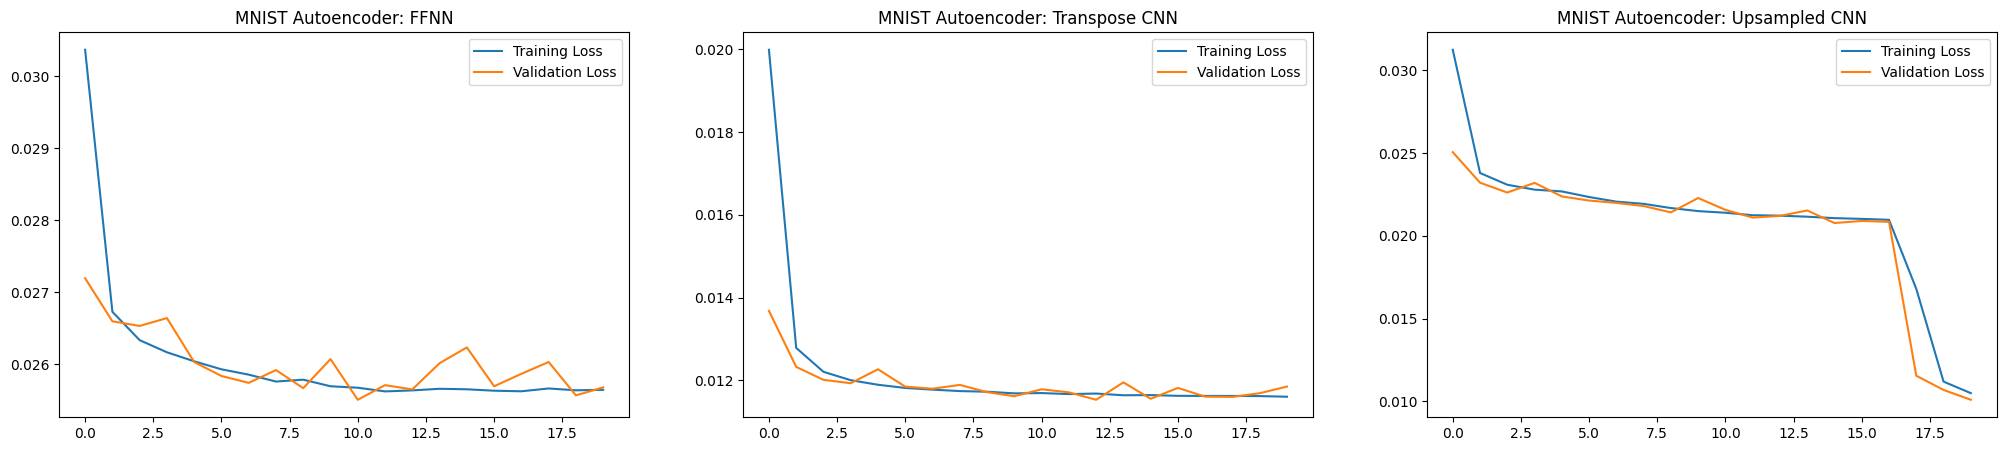

In [20]:
title=['FFNN','Transpose CNN','Upsampled CNN']
model_losses=[m1_loss,m2_loss,m3_loss]

fig=plt.figure(1,figsize=(25,5))
idx=1
for i in model_losses:
  ax=fig.add_subplot(1,3,idx)
  ax.plot(i['train'],label="Training Loss")
  ax.plot(i['valid'],label="Validation Loss")
  ax.set_title('MNIST Autoencoder: '+title[idx-1])
  idx+=1
  plt.legend();

## Testing Phase

In [23]:
def test(model,state='fully'):
    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, _ = next(dataiter)
    if use_cuda and torch.cuda.is_available():
        images=images.cuda()
    if state=='fully':
        images = images.view(images.size(0), -1)

    # get sample outputs
    output = model(images)
    # prep images for display
    images = images.cpu().numpy()
    # output is resized into a batch of images
    output = output.view(batch_size, 1, 28, 28)
    # use detach when it's an output that requires_grad
    output = output.cpu().detach().numpy()


    # plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

    # input images on top row, reconstructions on bottom
    for images, row in zip([images, output], axes):
        for img, ax in zip(images, row):
            if state=='fully':
                img = img.reshape(1, 28, 28)
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

## FFNN Autoencoder

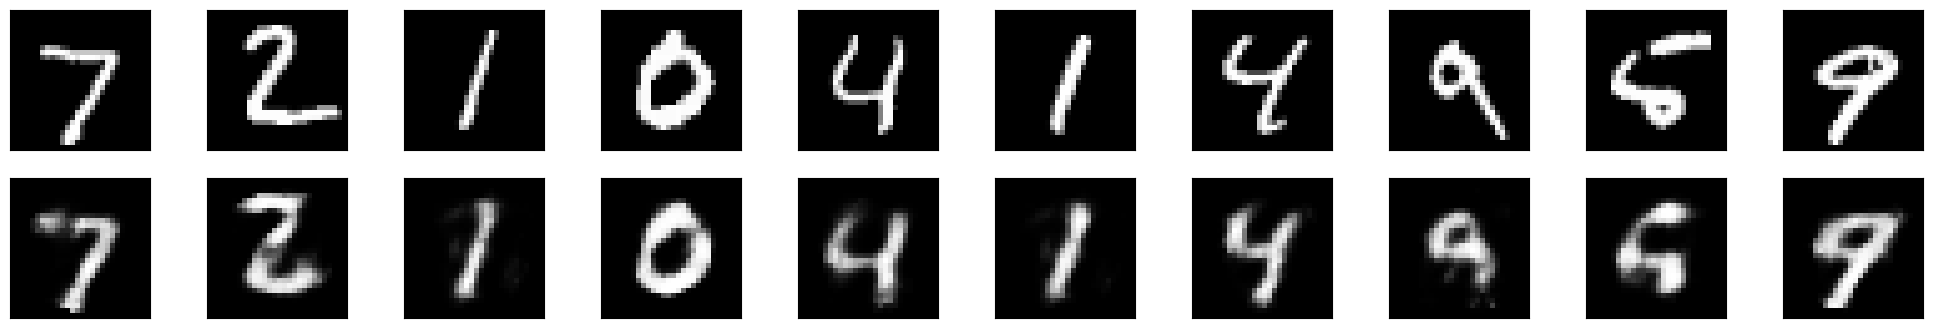

In [24]:
test(model_1)

## Transpose CNN Autoencoder

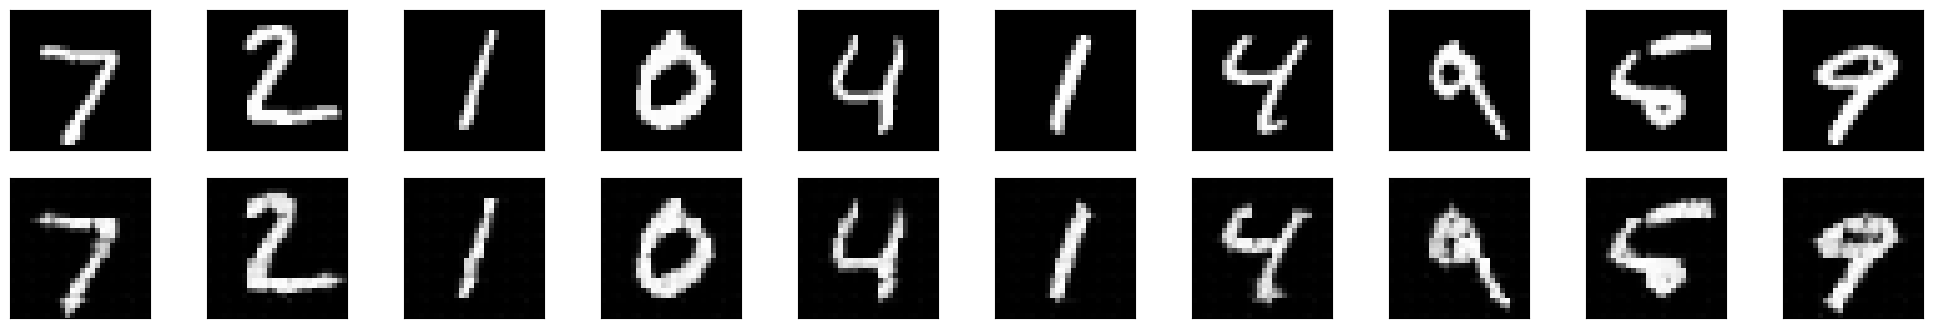

In [25]:
test(model_2,'conv')

## Upsampled CNN Autoencoder

/tmp/ipython-input-219568314.py:42: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  x = F.upsample(x, scale_factor=2, mode='nearest')
/tmp/ipython-input-219568314.py:44: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  x = F.upsample(x, scale_factor=2, mode='nearest')


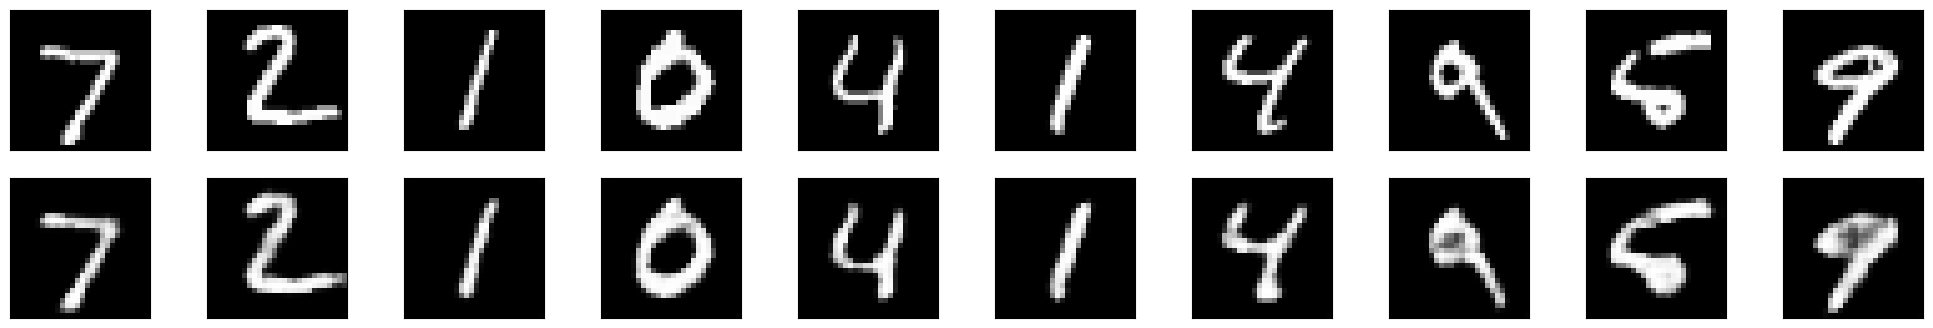

In [26]:
test(model_3,'conv')